In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 40
n_loci = 50
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

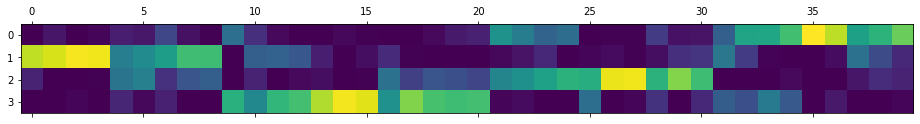

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(40, 50, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (40, 7) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (40, 7) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 143241)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

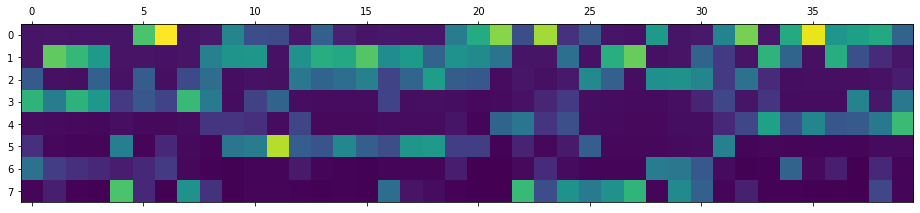

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

In [14]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            gh_loc, gh_weights)

DeviceArray(10045.96122165, dtype=float64)

In [15]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

# Check preconditioners

In [16]:
import vb_lib.preconditioner_lib as preconditioner_lib
import vb_lib.preconditioner_lib_autograd as preconditioner_lib_autograd

In [17]:
mfvb_cov = preconditioner_lib_autograd.get_mfvb_cov(vb_params_dict, vb_params_paragami,
                    use_logitnormal_sticks,
                    return_info = False)

mfvb_info = preconditioner_lib_autograd.get_mfvb_cov(vb_params_dict, vb_params_paragami,
                    use_logitnormal_sticks,
                    return_info = True)

In [18]:
cov_matmul = jax.jit(lambda v : preconditioner_lib.get_mfvb_cov_matmul(v, 
                                    vb_params_dict,
                                    vb_params_paragami,
                                    return_info = False))

info_matmul = jax.jit(lambda v : preconditioner_lib.get_mfvb_cov_matmul(v, 
                                    vb_params_dict,
                                    vb_params_paragami,
                                    return_info = True))

In [19]:
v = vb_params_free

In [20]:
import numpy as onp

In [21]:
# check covariances

for i in range(len(vb_params_free)): 
    
    e_i = onp.zeros(len(vb_params_free))
    e_i[i] = 1.
    
    out1 = cov_matmul(e_i)
    out2 = mfvb_cov.dot(e_i)

    assert np.abs(out2 - out1).max() < 1e-8

In [22]:
# check infos

for i in range(len(vb_params_free)): 
    
    e_i = onp.zeros(len(vb_params_free))
    e_i[i] = 1.
    
    out1 = info_matmul(e_i)
    out2 = mfvb_info.dot(e_i)

    assert np.abs(out2 - out1).max() < 1e-8